# Считаем среднюю длительность победного рана Аукуса

1. Моделируем длительность средней игры на ауке;
2. Моделируем простое около-оптимальное поведение агента;
3. На Монте-Карлычах считаем среднюю длину в часах до победы, std, лучший ран и худший.

## Шаг 1: Моделирование длительности игры, выпавшей с аука

1. Берём все игры стримаков с Аукуса 2 (файлик `aukus2_games.csv`);
2. Подтягиваем данные с ХЛТБ, дропаем неподтянувшиеся;
3. Хуярим гистограмму, используем её как плотность случайной величины длительности игры.

Допущения/послабления на этом шаге:
1. У разных стримеров разные аудитории, и реальная плотность будет отличаться от "усреднённой";
2. Реальная плотность неоднорода: в зависимости от положения стримера на карте на ауках кидают качественно разные игры. Например, на 101 клетке очень большой % коротулек и очень большой % 50+ часов непроходимого говна;
3. Неподтянутые игры с ХЛТБ надо подтянуть.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from functools import total_ordering

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# pip install howlongtobeatpy
from howlongtobeatpy import HowLongToBeat

aukus2_games = pd.read_csv('aukus2_games.csv')

def get_hltb_main_story_time_hours(game_name):
    # print('Getting main story time for', game_name)
    hltb_result = HowLongToBeat().search(game_name)
    if not hltb_result:
        # print(game_name, 'hltb was not found, returning 0')
        return 0
    
    return HowLongToBeat().search(game_name)[0].main_story

def get_all_hltb_times_hours():
    streamer_to_hltbs = {}
    
    for streamer in aukus2_games.columns:
        streamer_games = aukus2_games[streamer][~aukus2_games[streamer].isna()].reset_index(drop=True)
        streamer_hltbs = list(map(get_hltb_main_story_time_hours, streamer_games))
        streamer_to_hltbs[streamer] = streamer_hltbs
        
    all_hltbs = [item for sublist in streamer_to_hltbs.values() for item in sublist]
    # дропаем неподтянувшиеся нахуй
    all_hltbs = [num for num in all_hltbs if num != 0]

    return all_hltbs

def get_game_time_hours_rv(all_hltb_times_hours):
    return stats.rv_histogram(np.histogram(all_hltb_times_hours, bins=40), density=False)

In [ ]:
all_hltbs = get_all_hltb_times_hours()

[Text(0.5, 0, 'Game duration hours')]

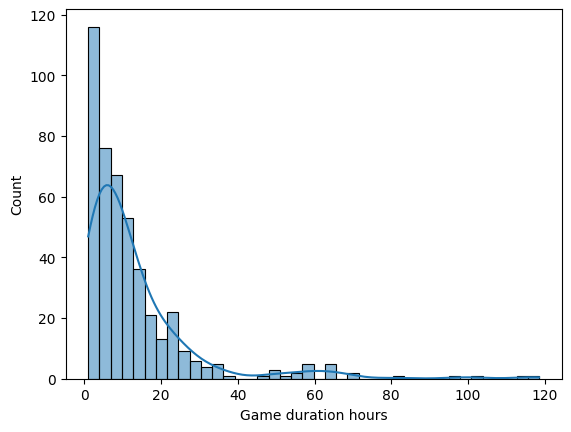

In [42]:
ax = sns.histplot(all_hltbs, bins=40, kde=True)
ax.set(xlabel='Game duration hours')

In [8]:
game_time_hours_rv = get_game_time_hours_rv(all_hltbs)

## Шаг 2: Моделирование карты и действий агента

Допущения/послабления на этом шаге:
1. Продолжительность аука топорно предполагается нормально распределённой со средним значением 30 минут и стандартным отклонением в 3 минуты;
2. Шанс дропа шейхом не на 101 клетке - 2% после каждого аука, на 101 клетке - шейх всегда пытается дропнуть 3 раза.

In [11]:
AVG_AUK_TIME_MINUTES = 30
AUK_TIME_STD = 3

RANDOM_SHEIKH_DROP_CHANCE = 0.02

def roll_auk_time_minutes():
    return np.random.normal(AVG_AUK_TIME_MINUTES, AUK_TIME_STD)

def roll_game_time_minutes():
    return game_time_hours_rv.rvs() * 60

def sheikh_drop(current_cell, game_time_minutes):
    if current_cell == 101:
        return np.random.binomial(3, 0.5) != 0
    else:
        return np.random.binomial(1, RANDOM_SHEIKH_DROP_CHANCE) == 1

Лестницы и горки присутствуют. Игрок не может выкатиться за клетку 0 при отрицательном ролле. Игрок оказывается на 101 клетке обязательно, перед тем как пройти дальше.

In [10]:
stairs = {
    1: 20,
    4: 25,
    13: 46,
    33: 49,
    42: 63,
    44: 68,
    50: 69,
    62: 81,
    71: 90,
    74: 92
}

tubes = {
    21: 3,
    27: 5,
    43: 18,
    47: 11,
    54: 31,
    66: 45,
    76: 58,
    89: 53,
    94: 67,
    96: 84,
    97: 85,
    99: 41
}

def move(current_cell, dice_roll):
    if dice_roll < 0:
        current_cell = max(current_cell + dice_roll, 0)
    else:
        if current_cell == 101:
            current_cell += dice_roll
        else:
            current_cell = min(current_cell + dice_roll, 101)
    
    if current_cell in stairs:
        current_cell = stairs[current_cell]
    
    if current_cell in tubes:
        current_cell = tubes[current_cell]
    
    return current_cell

Агент бросает кубик(и) в зависимости от продолжительности игры, статуса дропа игры, текущего положения на карте и целесообразности броска 1 или 2 кубиков. Кубики честные, шестисторонние.

In [9]:
def roll_dice(current_cell, game_was_dropped, rolled_game_time_minutes, one_roll_better):
    if game_was_dropped:
        if current_cell < 81:
            return -np.random.randint(1, 7)
        else:
            return -np.random.randint(1, 7) - np.random.randint(1, 7)        
    else:
        if current_cell < 81:
            if rolled_game_time_minutes < 15 * 60 or one_roll_better:
                return np.random.randint(1, 7)
            else:
                return np.random.randint(1, 7) + np.random.randint(1, 7)
        else:
            return np.random.randint(1, 7)

На 101 клетке агент будет дропать только игры дольше 60 часов по хлтб.
На остальных клетках агент будет дропать только игры дольше 24 часов.
Также, если позади агента находятся "хорошие" лестницы, то ему тоже есть смысл дропать: если в досягаемости 1 кубика сзади лестниц больше, чем горок.

In [14]:
def drop_makes_sense(current_cell, game_time_minutes):
    if current_cell == 101 and game_time_minutes < 60 * 60:
        return False
    
    if game_time_minutes > 24 * 60:
        return True
    
    if good_stairs_behind(current_cell, game_time_minutes):
        return True
    
    return False

def good_stairs_behind(current_cell, game_time_minutes):
    stairs_count = 0
    tubes_count = 0
    
    for i in range(1, 7):
        if current_cell - i in stairs:
            stairs_count += 1
        if current_cell - i in tubes:
            tubes_count += 1
        
    return stairs_count > tubes_count

## Моделирование 1 рана Аукуса

Ран происходит до тех пор, пока агент не выбрался на 102 клетку или дальше. Цикл прост:
1. Потратили время на аук, наролили игру;
2. Решили, дропать игру или нет (по "оптимальной" игре или из-за шейха);
3. Если дропаем, добавляем час, если нет - добавляем время игры по ХЛТБ;
4. Ролим кубик(и), переходим на новую клетку;
5. Записываем ход в историю.

Допущения/послабления:
1. Полно игр с длительностью 15+ часов, которые стримеры проходят куда быстрее.

In [16]:
@total_ordering
class AukusRunHistory():
    
    def __init__(self, hours_spent=0, history=[]):
        self.hours_spent = hours_spent
        self.history = history
        
    def __eq__(self, other):
        return self.hours_spent == other.hours_spent
    
    def __lt__(self, other):
        return self.hours_spent < other.hours_spent
    
    def __str__(self):
        return str(self.hours_spent)
    
    def __repr__(self):
        return str(self.hours_spent)

def aukus_run_hours():
    current_cell = 0
    minutes_spent = 0
    history = []
    
    while current_cell < 102:
        minutes_spent += roll_auk_time_minutes()
        
        rolled_game_time_minutes = roll_game_time_minutes()
        
        game_dropped = drop_makes_sense(current_cell, rolled_game_time_minutes)
        if not game_dropped:
            game_dropped = sheikh_drop(current_cell, rolled_game_time_minutes)
        
        if game_dropped:
            minutes_spent += 65 # min 60 minutes game time + 5 minutes trivia
        else:
            minutes_spent += rolled_game_time_minutes
        
        game_completion_dice_roll = roll_dice(current_cell, game_dropped, rolled_game_time_minutes, False)
        
        new_cell = move(current_cell, game_completion_dice_roll)
        
        history.append((current_cell, rolled_game_time_minutes / 60, game_completion_dice_roll, new_cell))
        
        current_cell = new_cell
    
    return AukusRunHistory(minutes_spent / 60, history)

## Шаг 3: Монте-Карло симу

In [21]:
def mc_aukus(N):
    np.random.seed(42)
    
    aukus_histories = []
    
    for run in range(N):
        aukus_histories.append(aukus_run_hours())
        # if run % (N / 100) == 0:
        #     print(run / N * 100, '% done')
    
    aukus_times_hours = list(map(lambda history: history.hours_spent, aukus_histories))
    
    return np.mean(aukus_times_hours), np.std(aukus_times_hours), np.min(aukus_histories), np.max(aukus_histories), aukus_histories

In [22]:
aukus_mean_hours, aukus_std, best_run, slowest_run, histories = mc_aukus(10000)

In [23]:
aukus_mean_hours, aukus_std, best_run, slowest_run

(4370.985709257422, 4165.4796656008675, 82.88811065110298, 34498.20143923202)

0.07800238069514143

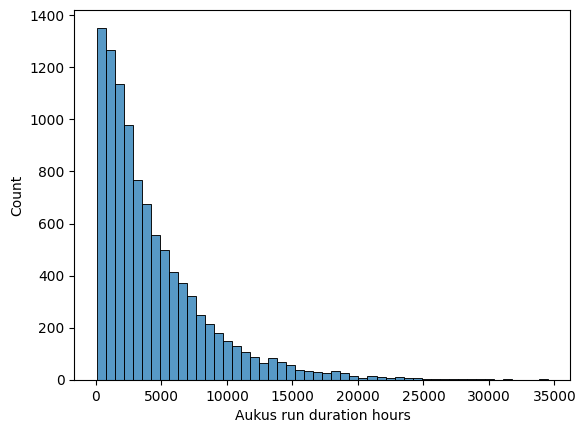

In [44]:
aukus_times_hours = np.array(list(map(lambda history: history.hours_spent, histories)))
ax = sns.histplot(aukus_times_hours, bins=50)
ax.set(xlabel='Aukus run duration hours')
stats.rv_histogram(np.histogram(aukus_times_hours, bins=50), density=False).cdf(480)

# Результаты

* Продолжительность среднего рана: 4370 часов (~273 дня стримов по 16 часов)
* Стандартное отклонение: 4165 часов (пизда)
* Лучший ран: 82 часа
* Худший ран: 34500 часов...
* Всего лишь 7.8% ранов укладываются в 480 часов (30 дней стримов по 16 часов)

In [26]:
best_run.history

[(0, 1.5773649874583981, 4, 25),
 (25, 2.0948124284976197, 3, 28),
 (28, 29.0456376348421, -3, 25),
 (25, 3.5164306376631567, 4, 29),
 (29, 3.612842121224763, -4, 25),
 (25, 6.129350593452612, 6, 31),
 (31, 34.967197580811664, -5, 26),
 (26, 10.483202078011997, 5, 31),
 (31, 3.036155332454153, 2, 49),
 (49, 1.6017022873074613, 1, 69),
 (69, 2.0445694137667307, 5, 92),
 (92, 6.566677074698573, 3, 95),
 (95, 14.863065302017123, 5, 100),
 (100, 4.523933853489077, 1, 101),
 (101, 15.681334169257685, 1, 102)]